In [1]:
import torch
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
image = []
image.append(Image.open("ilsvrc2012-sample-images/i1.jpg"))
image.append(Image.open("ilsvrc2012-sample-images/i2.jpg"))
image.append(Image.open("ilsvrc2012-sample-images/i3.jpg"))
image.append(Image.open("ilsvrc2012-sample-images/i4.jpg"))
image.append(Image.open("ilsvrc2012-sample-images/i5.jpg"))

In [3]:
weights = ResNet50_Weights.IMAGENET1K_V2
preprocess = weights.transforms()
resnet50 = resnet50(weights=weights)
resnet50.eval()

tensorToImage = transforms.ToPILImage()
ImageToTensor = transforms.ToTensor()
resizeImage = transforms.Compose([transforms.ToTensor(),transforms.Resize(232),transforms.CenterCrop(224),transforms.ToPILImage()])

In [4]:
class VanillaBackprop():
    def __init__(self, model):
        self.model = model
        self.preprocess = preprocess 
    
    def preprocessImage(self,input_image):
        preprocessed_image = self.preprocess(input_image)
        preprocessed_image = preprocessed_image.unsqueeze(0)
        return preprocessed_image

    def run(self,input_image):
        input_tensor = self.preprocessImage(input_image)
        input_tensor.requires_grad = True

        # FORWARD AND BACK PROP
        logits = self.model(input_tensor)
        argmax = torch.argmax(logits)
        labels = torch.zeros_like(logits)
        labels[0][argmax] = 1
        self.model.zero_grad()
        logits.backward(gradient=labels)

        gradient = input_tensor.grad[0]
        gradient = gradient - gradient.min()
        gradient /= gradient.max()
        gradient_image = tensorToImage(gradient)
        plt.subplot(1,2,1)
        plt.imshow(resizeImage(input_image))
        plt.subplot(1,2,2)
        plt.imshow(gradient_image)


In [5]:
def convertImage(gradient):
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    pil_image = tensorToImage(gradient)
    return pil_image


/home/cs20btech11018/anaconda3/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


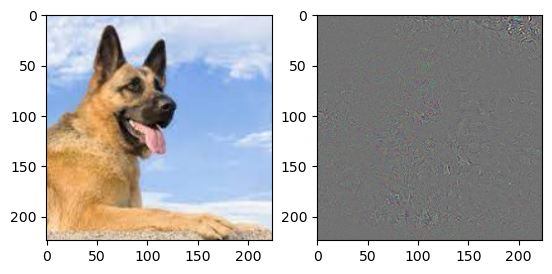

In [6]:
back_prop = VanillaBackprop(resnet50)
back_prop.run(image[0])

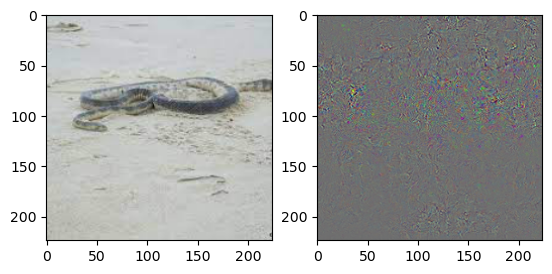

In [7]:
back_prop.run(image[1])

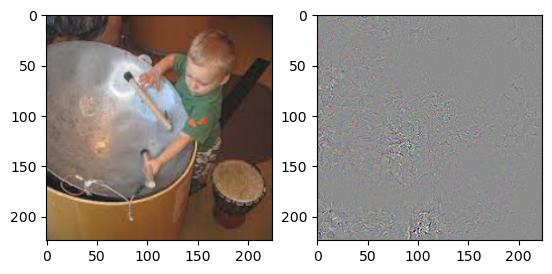

In [8]:
back_prop.run(image[2])

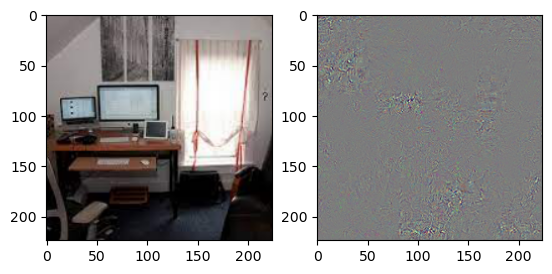

In [9]:
back_prop.run(image[3])

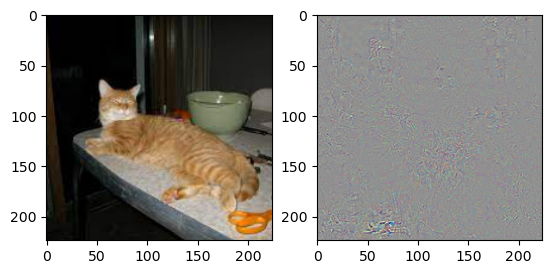

In [10]:
back_prop.run(image[4])

# Guided Back Propagation

In [11]:
class GuidedBackprop():
    def __init__(self, model):
        self.model = model
        self.preprocess = preprocess
        self.image = None
        self.gradient_image = None
        self.gradients = None
        self.handles = []
    def preprocessImage(self,input_image):
        preprocessed_image = self.preprocess(input_image)
        preprocessed_image = preprocessed_image.unsqueeze(0)
        return preprocessed_image
    def run(self,input_image):
        self.image = input_image
        input_tensor = self.preprocessImage(input_image)
        input_tensor.requires_grad = True
        
        def relu_backward_hook_fn(module, grad_in, grad_out):
            return (torch.clamp(grad_in[0], min=0.0),)

        for module in self.model.modules():
            if type(module) == torch.nn.ReLU:
                self.handles.append(module.register_backward_hook(relu_backward_hook_fn))
        # FORWARD AND BACK PROP
        logits = self.model(input_tensor)
        argmax = torch.argmax(logits)
        one_hot_output = torch.zeros_like(logits)
        one_hot_output[0][argmax] = 1
        self.model.zero_grad()
        logits.backward(gradient=one_hot_output)

        for handle in self.handles:
            handle.remove()
        
        self.gradient_image = convertImage(input_tensor.grad[0])

    def display(self):
        plt.subplot(1,2,1)
        plt.imshow(resizeImage(self.image))
        plt.subplot(1,2,2)
        plt.imshow(self.gradient_image)
    
    def run_and_display(self,image):
        self.run(image)
        self.display()

/home/cs20btech11018/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


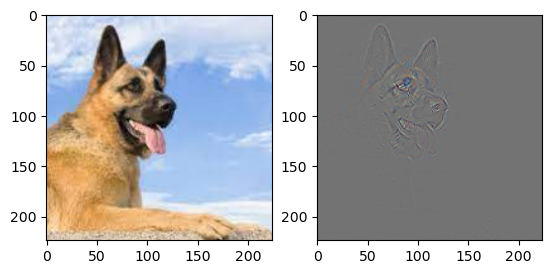

In [12]:
guided_back_prop = GuidedBackprop(resnet50)
guided_back_prop.run_and_display(image[0])


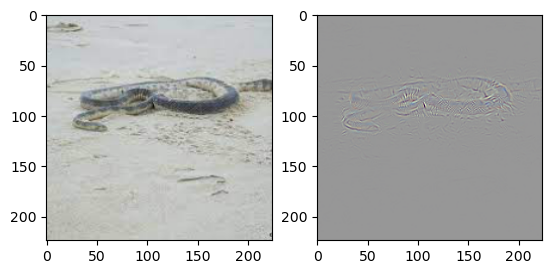

In [13]:
guided_back_prop.run_and_display(image[1])


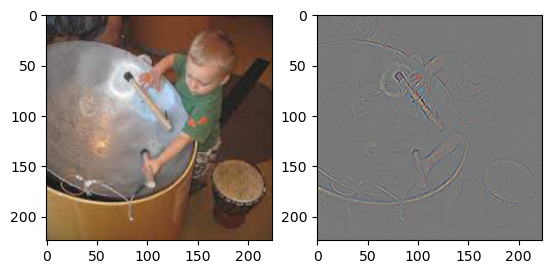

In [14]:
guided_back_prop.run_and_display(image[2])


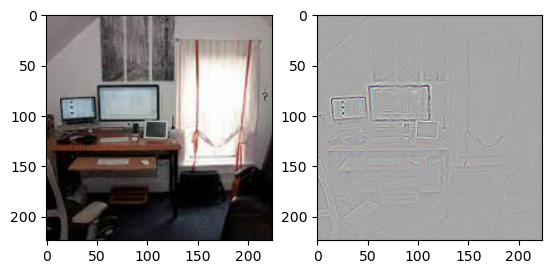

In [15]:
guided_back_prop.run_and_display(image[3])


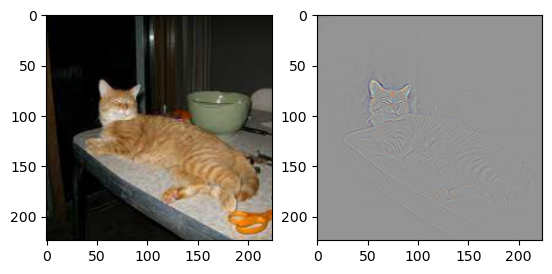

In [16]:
guided_back_prop.run_and_display(image[4])

# Class Activation Maps

## CAM

In [17]:
class CAM():
    def __init__(self, model):
        self.model = model
        self.preprocess = preprocess
        self.image = None
        self.cam_image = None
        self.last_conv_layer = model.layer4
        self.last_conv_layer_output = None
        self.last_conv_layer_gradients = None
        self.handles = []

    def preprocessImage(self, input_image):
        preprocessed_image = self.preprocess(input_image)
        preprocessed_image = preprocessed_image.unsqueeze(0)
        return preprocessed_image

    def run(self, input_image):
        input_tensor = self.preprocessImage(input_image)
        # Register foward hook to the last conv layer

        def save_output_hook(module, input, output):
            self.last_conv_layer_output = output

        self.last_conv_layer.register_forward_hook(save_output_hook)

        # forward pass
        logits = self.model(input_tensor)
        argmax = torch.argmax(logits)
        

        W_k = list(resnet50.parameters())[-2][argmax].unsqueeze(1).unsqueeze(1)

        # cam_k = sum_k alpha_k * A_ij^k
        self.last_conv_layer_output = self.last_conv_layer_output[0]
        cam_k = torch.sum(
            W_k * self.last_conv_layer_output, dim=(0), keepdim=True)
        cam_k = cam_k[0]

        # form a heat map
        cam_img = cam_k.detach().numpy()
        cam_img = cam_img - np.min(cam_img)
        cam_img = cam_img / np.max(cam_img)
        cam_img = np.uint8(255 * cam_img)
        cam_img = Image.fromarray(cam_img).resize((224, 224), Image.Resampling.LANCZOS)
        self.cam_image = cam_img

    def display(self):

        plt.subplot(1, 2, 1)
        plt.imshow(resizeImage(self.image))
        plt.subplot(1, 2, 2)
        plt.imshow(self.cam_image)

    def run_and_display(self, image):
        self.image = image
        self.run(image)
        self.display()


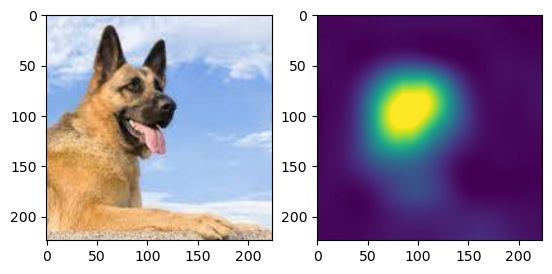

In [18]:
CAM = CAM(resnet50)
CAM.run_and_display(image[0])

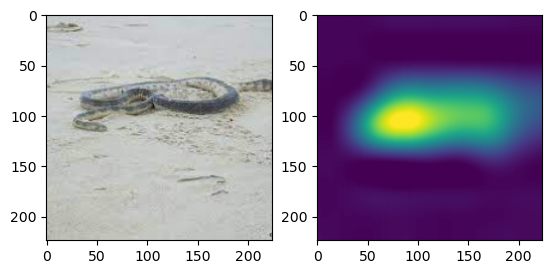

In [19]:
CAM.run_and_display(image[1])

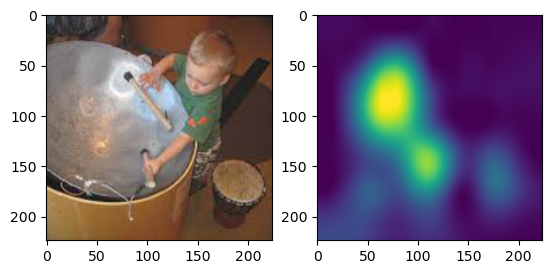

In [20]:
CAM.run_and_display(image[2])

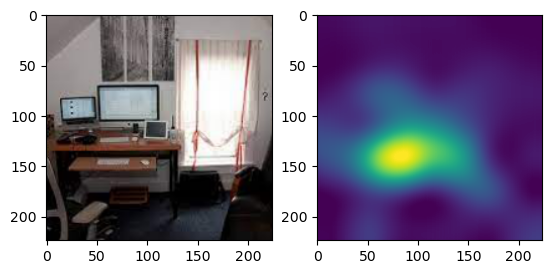

In [21]:
CAM.run_and_display(image[3])

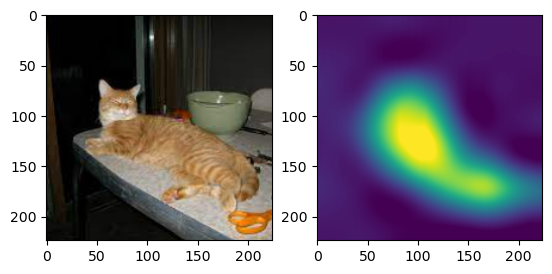

In [22]:
CAM.run_and_display(image[4])

## grad-CAM

In [23]:
class gradCAM():
    def __init__(self, model):
        self.model = model
        self.preprocess = preprocess
        self.image = None
        self.cam_image = None
        self.last_conv_layer = model.layer4
        self.last_conv_layer_output = None
        self.last_conv_layer_gradients = None
        self.handles = []

    def preprocessImage(self,input_image):
        preprocessed_image = self.preprocess(input_image)
        preprocessed_image = preprocessed_image.unsqueeze(0)
        return preprocessed_image
    
    def run(self,input_image):        
        input_tensor = self.preprocessImage(input_image)
        # Register foward hook to the last conv layer
        def save_output_hook(module, input, output):
            self.last_conv_layer_output = output
        # Register backward hook to the last conv layer for storing gradients
        def save_gradients_hook(module, grad_in, grad_out):
            self.last_conv_layer_gradients = grad_out[0]
        
        self.last_conv_layer.register_backward_hook(save_gradients_hook)
        self.last_conv_layer.register_forward_hook(save_output_hook)
        
        # Find gradients of y^c with respect to the last conv layer
        # forward and backward pass
        logits = self.model(input_tensor)
        one_hot = torch.zeros_like(logits)
        one_hot[0][torch.argmax(logits)] = 1

        self.model.zero_grad()
        logits.backward(gradient=one_hot)
                
        self.last_conv_layer_gradients = self.last_conv_layer_gradients[0]
        # alpha_k = sum_i sum_j (dy^c/dA_ij^k)
        alpha_k = torch.mean(self.last_conv_layer_gradients, dim=(1,2), keepdim=True)
        
        # cam_k = sum_k alpha_k * A_ij^k
        self.last_conv_layer_output = self.last_conv_layer_output[0]
        cam_k = torch.sum(alpha_k * self.last_conv_layer_output, dim=(0),keepdim=True)
        cam_k = cam_k[0]
        
        # form a heat map
        cam_img = cam_k.detach().numpy()
        cam_img = cam_img - np.min(cam_img)
        cam_img = cam_img / np.max(cam_img)
        cam_img = np.uint8(255 * cam_img)
        cam_img = Image.fromarray(cam_img).resize((224,224), Image.Resampling.LANCZOS)
        self.cam_image = cam_img
    
    def display(self):
    
        plt.subplot(1,2,1)
        plt.imshow(resizeImage(self.image))
        plt.subplot(1,2,2)
        plt.imshow(self.cam_image)
    
    def run_and_display(self,image):
        self.image = image
        self.run(image)
        self.display()

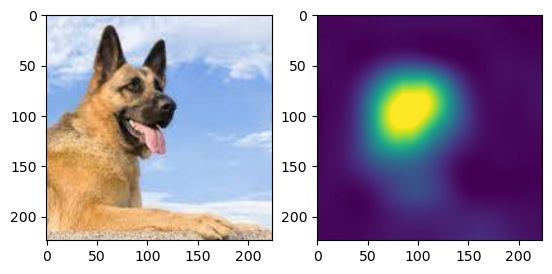

In [24]:
grad_cam = gradCAM(resnet50)
grad_cam.run_and_display(image[0])

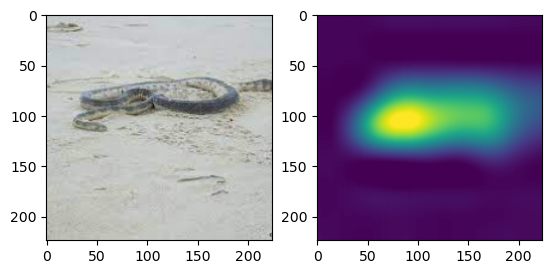

In [25]:
grad_cam.run_and_display(image[1])

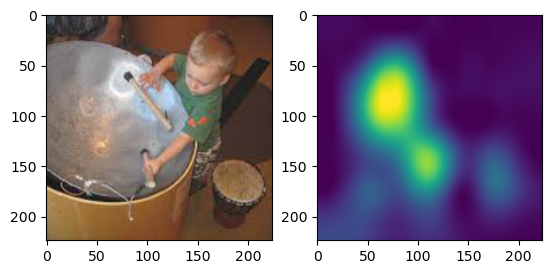

In [26]:
grad_cam.run_and_display(image[2])

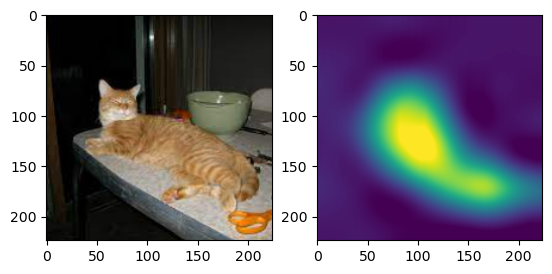

In [27]:
grad_cam.run_and_display(image[4])

# Guided Grad-CAM

In [28]:
class guidedGradCAM():
    def __init__(self,model):
        self.model = model
        self.gradCAM = gradCAM(model)
        self.guidedBackprop = GuidedBackprop(model)
        self.preprocess = preprocess
        self.image = None
        self.guided_grad_cam_image = None
    
    def preprocessImage(self,input_image):
        preprocessed_image = self.preprocess(input_image)
        preprocessed_image = preprocessed_image.unsqueeze(0)
        return preprocessed_image

    def run(self,input_image):
        self.gradCAM.run(input_image)
        cam_tensor = ImageToTensor(self.gradCAM.cam_image)
        self.guidedBackprop.run(input_image)
        guided_backprop_tensor = ImageToTensor(self.guidedBackprop.gradient_image)
        guided_backprop_tensor[0] = guided_backprop_tensor[0] * cam_tensor[0]
        guided_backprop_tensor[1] = guided_backprop_tensor[1] * cam_tensor[0]
        guided_backprop_tensor[2] = guided_backprop_tensor[2] * cam_tensor[0]
        self.guided_grad_cam_image = tensorToImage(guided_backprop_tensor)
    
    def display(self):
        plt.subplot(1,2,1)
        plt.imshow(resizeImage(self.image))
        plt.subplot(1,2,2)
        plt.imshow(self.guided_grad_cam_image)
    
    def run_and_display(self,image):
        self.image = image
        self.run(image)
        self.display()

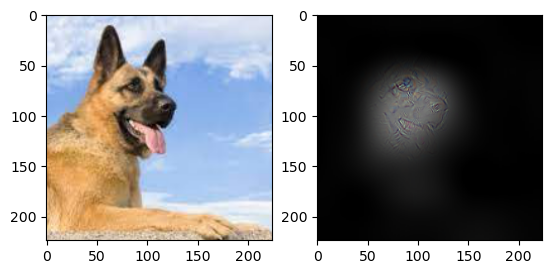

In [29]:
guidedGradCAM = guidedGradCAM(resnet50)
guidedGradCAM.run_and_display(image[0])

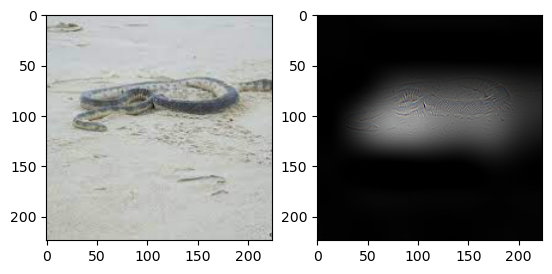

In [30]:
guidedGradCAM.run_and_display(image[1])

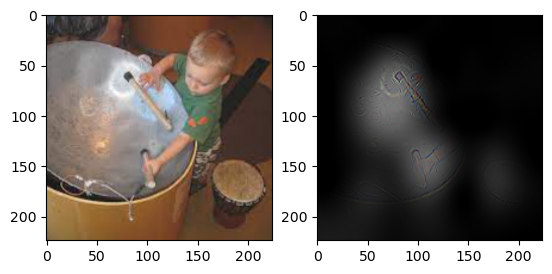

In [31]:
guidedGradCAM.run_and_display(image[2])

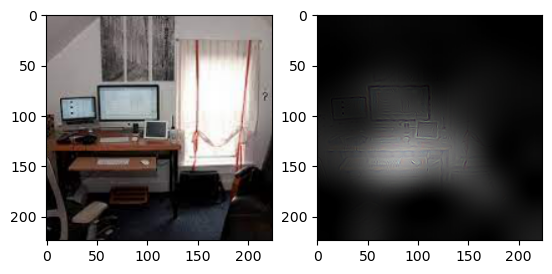

In [32]:
guidedGradCAM.run_and_display(image[3])

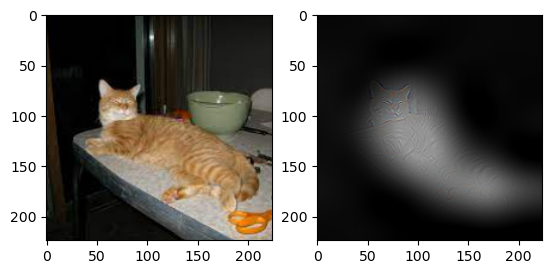

In [33]:
guidedGradCAM.run_and_display(image[4])

# Problem 2

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [35]:
#vanilla gradient descent
def gradient_descent(x0,y0,dfdx,dfdy,lr=0.01,max_iterations=10):
    x = x0
    y = y0
    lx = [x]
    ly = [y]
    for i in range(max_iterations):
        x = x - lr*dfdx(x,y)
        y = y - lr*dfdy(x,y)
        lx.append(x)
        ly.append(y)
    return lx,ly

In [36]:
#SGD with momentum gradient descent
def momentum_gradient_descent(x0,y0,dfdx,dfdy,lr=0.01,max_iterations=300,momentum=0.9):
    x = x0
    y = y0
    lx = [x]
    ly = [y]
    vx = 0
    vy = 0
    for i in range(max_iterations):
        vx = momentum*vx + dfdx(x,y)
        vy = momentum*vy + dfdy(x,y)
        x = x -lr*vx
        y = y -lr*vy
        lx.append(x)
        ly.append(y)
    return lx,ly

In [37]:
def nestrov_momentum_gradient_descent(x0, y0, dfdx, dfdy, lr=0.01, max_iterations=300, momentum=0.9):
    x = x0
    y = y0
    lx = [x]
    ly = [y]
    vx = 0
    vy = 0
    for i in range(max_iterations):
        vx_prev = vx
        vx_prev = vy
        vx = momentum*vx - lr*dfdx(x, y)
        vy = momentum*vy - lr*dfdy(x, y)
        x += -momentum*vx_prev + (1+momentum)*vx
        y += -momentum*vx_prev + (1+momentum)*vy
        lx.append(x)
        ly.append(y)
        
    return lx, ly


In [38]:
# AdaGrad gradient descent
def adagrad_gradient_descent(x0,y0,dfdx,dfdy,lr=0.01,max_iterations=300,epsilon=0.0):
    x = x0
    y = y0
    lx = [x]
    ly = [y]
    vx = 0
    vy = 0
    for i in range(max_iterations):
        vx = vx + dfdx(x,y)**2
        vy = vy + dfdy(x,y)**2
        x = x - lr*dfdx(x,y)/(np.sqrt(vx)+epsilon)
        y = y - lr*dfdy(x,y)/(np.sqrt(vy)+epsilon)
        lx.append(x)
        ly.append(y)
    return lx,ly

In [39]:
# RMSProp gradient descent
def rmsprop_gradient_descent(x0,y0,dfdx,dfdy,lr=0.01,eplision=0.0,max_iterations=300,alpha=0.9,epsilon=0.0):
    x = x0
    y = y0
    lx = [x]
    ly = [y]
    vx = 0
    vy = 0
    bx = 0
    by = 0
    for i in range(max_iterations):
        vx = alpha*vx + (1-alpha)*dfdx(x,y)**2
        vy = alpha*vy + (1-alpha)*dfdy(x,y)**2
        x = x - lr*dfdx(x, y)/(np.sqrt(vx)+epsilon)
        y = y - lr*dfdy(x, y)/(np.sqrt(vy)+epsilon)
        lx.append(x)
        ly.append(y)
    return lx,ly

In [40]:
#f =  y^2 + 10x^2
def dfdy(x,y):
    return 2*y
def dfdx(x,y):
    return 20*x

In [41]:
x0=2
y0=2
iters=30
x_grad,y_grad = gradient_descent(x0,y0,dfdx,dfdy,lr=0.02,max_iterations=100)
x_grad_mom,y_grad_mom = momentum_gradient_descent(x0,y0,dfdx,dfdy,lr=0.02,max_iterations=100,momentum=0.2)
x_grad_nest,y_grad_nest = nestrov_momentum_gradient_descent(x0,y0,dfdx,dfdy,lr=0.02,max_iterations=100,momentum=0.2)
x_grad_adagrad,y_grad_adagrad = adagrad_gradient_descent(x0,y0,dfdx,dfdy,lr=0.9999,max_iterations=100)
x_grad_rms,y_grad_rms = rmsprop_gradient_descent(x0,y0,dfdx,dfdy,lr=0.2,max_iterations=100,alpha=0.2)

# print(x_grad)
# print(x_grad_mom)
# print(x_grad_nest)
# print(x_grad_adagrad)
# print(x_grad_rms)
# print(y_grad)
# print(y_grad_mom)
# print(y_grad_nest)
# print(y_grad_adagrad)
# print( y_grad_rms)

In [42]:
def create_frame(t):
    fig = plt.figure(figsize=(6, 6))
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    x = np.linspace(-2, 2)
    y = np.linspace(-2, 2)
    X, Y = np.meshgrid(x, y)
    Z = X**2 + 10*Y**2
    plt.contourf(X, Y, Z)
    plt.scatter(x_grad[:t], y_grad[:t], c='r', label="grad")
    plt.scatter(x_grad_mom[:t], y_grad_mom[:t], c='g', label="grad_mom")
    plt.scatter(x_grad_nest[:t], y_grad_nest[:t], c='b', label="grad_nest")
    plt.scatter(x_grad_adagrad[:t],
                y_grad_adagrad[:t], c='y', label="ada_grad")
    plt.scatter(x_grad_rms[:t], y_grad_rms[:t], c='k', label="rms_prop")
    plt.legend()
    plt.savefig(f'img/img_{t}.png')
    plt.close()


In [43]:
os.makedirs('img', exist_ok=True)

In [44]:
for t in range(100):
    create_frame(t)

In [ ]:
frames = []
for t in range(100):
    image = imageio.v2.imread(f'img/img_{t}.png')
    frames.append(image)

In [ ]:
imageio.mimsave('CS20BTECH11018_prob2.gif', # output gif
                frames,          # array of input frames
                fps = 5)         # optional: frames per second